In [32]:
import yaml
from yaml import Loader
import pandas as pd
! pip install matplotlib
! pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [83]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has_top_hit"
IN_TOP_5 = "in_top_5"
IN_TOP_10 = "in_top_10"
RANK = "rank"
SIZE_OVERLAP = "size_overlap"
SIMILARITY = "similarity"
GENESET = "geneset"
SOURCE_GENESET = "source_geneset"
GENESET_SIZE = "geneset_size"
TRUNCATION_FACTOR = "truncation_factor"
NUM_TERMS = "num_terms"


TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
MODELS = [TURBO, DAVINCI]

In [2]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison, Overlap

In [3]:
def load_comparisons():
    with open(f"../analysis/enrichment-summary.yaml") as f:
        obj = yaml.load(f, Loader)
        comps = [GeneSetComparison(**x) for x in obj]
        return comps

In [4]:
comps = load_comparisons()

In [5]:
comps[0].name

'EDS-0'

In [6]:
list(comps[0].__dict__.keys())

['name',
 'gene_symbols',
 'model',
 'payloads',
 'overlaps',
 'number_of_genes_swapped_out']

In [7]:
payload = comps[0].payloads["gpt-3.5-turbo.no_synopsis"]
list(payload.__dict__.keys())

['prompt',
 'response_text',
 'truncation_factor',
 'summary',
 'term_strings',
 'term_ids',
 'ontological_synopsis',
 'combined_synopsis',
 'annotations',
 'response_token_length',
 'model',
 'method']

In [84]:
def eval_payload(comp, method, payload, expected):
    name = comp.name
    model = payload.model
    # temp...
    if not model:
        toks = method.split(".")
        for m in MODELS:
            if method.startswith(m):
                model = m
                method = method.replace(f"{m}.", "")
                break
    if not model:
        model = "N/A"
    tf = payload.truncation_factor
    if not tf:
        tf = 1.0
    obj = {MODEL: model, METHOD: method, GENESET: name, TRUNCATION_FACTOR: tf}
    name_toks = name.split("-")
    obj[SOURCE_GENESET] = "-".join(name_toks[0:-1])
    if not expected.term_ids:
        #print(f"Nothing expected for {name}")
        # top_term_id = "FAKE:123"
        return
    else:
        top_term_id = expected.term_ids[0]
    obj[HAS_TOP_HIT] = top_term_id in payload.term_ids
    in_top_5 = False
    in_top_10 = False
    if top_term_id in payload.term_ids:
        rank = payload.term_ids.index(top_term_id)
        obj[RANK] = rank
        in_top_5 = rank < 5
        in_top_10 = rank < 10
    obj[IN_TOP_5] = in_top_5
    obj[IN_TOP_10] = in_top_10
    overlap = set(payload.term_ids).intersection(expected.term_ids)
    obj[SIZE_OVERLAP] = len(overlap)
    size_union = len(set(payload.term_ids).union(expected.term_ids))
    if size_union:
        obj['similarity'] = len(overlap) / len(set(payload.term_ids).union(expected.term_ids))
    obj['number_of_terms'] = len(payload.term_ids)
    obj[GENESET_SIZE] = len(comp.gene_symbols)
    obj['term_ids'] = payload.term_ids
    obj['term_strings'] = payload.term_strings
    obj[NUM_TERMS] = len(payload.term_ids)
    return obj

objs = []
for comp in comps:
    expected = comp.payloads["standard"]
    for method, payload in comp.payloads.items():
        obj = eval_payload(comp, method, payload, expected)
        if obj:
            objs.append(obj)
df = pd.DataFrame(objs)
df.to_csv("enr.csv")
df

,model,method,geneset,truncation_factor,source_geneset,has_top_hit,rank,in_top_5,in_top_10,size_overlap,similarity,number_of_terms,geneset_size,term_ids,term_strings,num_terms
0,gpt-3.5-turbo,no_synopsis,EDS-0,1.000000,EDS,True,2.0,True,True,2,0.045455,3,19,"[GO:0030198, GO:0030574, GO:0030199]","[extracellular matrix organization, collagen catabolic process, collagen fibril organization]",3
1,gpt-3.5-turbo,ontological_synopsis,EDS-0,1.000000,EDS,True,0.0,True,True,4,0.090909,5,19,"[GO:0030199, GO:0006024, GO:0030198, GO:0030166, MESH:D003871]","[collagen fibril organization, glycosaminoglycan biosynthetic process, extracellular matrix organization, proteoglycan biosynthetic process, and dermatan sulfate biosynthetic process]",5
2,gpt-3.5-turbo,narrative_synopsis,EDS-0,1.000000,EDS,True,1.0,True,True,2,0.045455,3,19,"[GO:0030198, GO:0030199, GO:0061448]","[extracellular matrix organization, collagen fibril organization, connective tissue development]",3
3,text-davinci-003,no_synopsis,EDS-0,1.000000,EDS,False,NaN,False,False,1,0.020408,7,19,"[MESH:D002477, GO:0032964, GO:0009101, GO:0009888, GO:0006024, sulfation pathway, MESH:D011509]","[cell-extracellular matrix interactions, collagen formation, glycoprotein synthesis, tissue development, glycosaminoglycan synthesis, sulfation pathway, proteoglycan assembly]",7
4,text-davinci-003,ontological_synopsis,EDS-0,1.000000,EDS,True,1.0,True,True,6,0.122449,12,19,"[GO:0005201, GO:0030199, GO:0030198, GO:0032964, GO:0000122, GO:0030166, GO:0050655, GO:0043588, GO:0000413, GO:0061448, GO:0071577, MESH:D015032]","[extracellular matrix structural constituent, collagen fibril organization, extracellular matrix organization, collagen biosynthetic process, negative regulation of transcription by rna polymerase ii, proteoglycan biosynthetic process, dermatan sulfate proteoglycan metabolic process, skin development, protein peptidyl-prolyl isomerization, connective tissue development, zinc ion transmembrane transport, and cellular zinc ion homeostasis]",12
5,text-davinci-003,narrative_synopsis,EDS-0,1.000000,EDS,False,NaN,False,False,1,0.020833,6,19,"[GO:0032964, MESH:D003238, GO:0030154, transcription regulation, GO:0042060, GO:0030166]","[collagen synthesis, connective tissue development, maintenance, and repair, cell differentiation, transcription regulation, wound healing, proteoglycan biosynthesis]",6
6,N/A,standard,EDS-0,1.000000,EDS,True,0.0,True,True,43,1.000000,43,19,"[GO:0030199, GO:0005201, GO:0005583, GO:0098643, GO:0030020, GO:0062023, GO:0098644, GO:0030198, GO:0043062, GO:0045229, GO:0005581, GO:0031012, GO:0030312, GO:0097435, GO:0048407, GO:1903053, GO:0030166, GO:0032963, GO:0005788, GO:0006024, GO:0006023, GO:0006029, GO:0046872, GO:1903225, GO:0085029, GO:0043169, GO:0030203, GO:0006022, GO:0005588, GO:0043588, GO:0005198, GO:0030208, GO:0005592, GO:1904026, GO:1903224, GO:0050651, GO:0043167, GO:0030205, GO:0048251, GO:0071230, GO:0046332, GO:0005783, GO:0050655]","[collagen fibril organization, extracellular matrix structural constituent, fibrillar collagen trimer, banded collagen fibril, extracellular matrix structural constituent conferring tensile strength, collagen-containing extracellular matrix, complex of collagen trimers, extracellular matrix organization, extracellular structure organization, external encapsulating structure organization, collagen trimer, extracellular matrix, external encapsulating structure, supramolecular fiber organization, platelet-derived growth factor binding, regulation of extracellular matrix organization, proteoglycan biosynthetic process, collagen metabolic process, endoplasmic reticulum lumen, glycosaminoglycan biosynthetic process, aminoglycan biosynthetic process, proteoglycan metabolic process, metal ion binding, negative regulation of endodermal cell differentiation, extracellular matrix assembly, cation binding, glycosaminoglycan metabolic process, aminoglycan metabolic process, collagen type V trimer, skin development, structura

In [85]:
df[[SOURCE_GENESET]].drop_duplicates()

,source_geneset
0,EDS
40,FA
80,HALLMARK_APICAL_JUNCTION
120,HALLMARK_GLYCOLYSIS
160,HALLMARK_MTORC1_SIGNALING
200,amigo-example
240,bicluster_RNAseqDB_1001
250,term-GO:0007212
290,meiosis I
330,mtorc1


In [87]:
eval_summary_cols = [MODEL, METHOD, HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS]
df[eval_summary_cols].groupby([MODEL, METHOD]).mean(numeric_only=True)

has_top_hit  in_top_5  in_top_10  \
model            method                                                   
N/A              random                   0.044444  0.000000   0.000000   
                 rank_based               0.088889  0.000000   0.000000   
                 standard                 1.000000  1.000000   1.000000   
                 standard_no_ontology     0.000000  0.000000   0.000000   
gpt-3.5-turbo    narrative_synopsis       0.422222  0.422222   0.422222   
                 no_synopsis              0.288889  0.288889   0.288889   
                 ontological_synopsis     0.377778  0.377778   0.377778   
text-davinci-003 narrative_synopsis       0.155556  0.155556   0.155556   
                 no_synopsis              0.155556  0.133333   0.155556   
                 ontological_synopsis     0.200000  0.155556   0.200000   

                                       size_overlap  similarity   num_terms  
model            method                                                      
N/A              random                    5.511111    0.015423   78.400000  
                 rank_based               10.733333    0.029012   88.711111  
                 standard                164.355556    1.000000  164.355556  
                 standard_no_ontology      0.000000    0.000000    0.000000  
gpt-3.5-turbo    narrative_synopsis        2.466667    0.025102    5.533333  
                 no_synopsis               2.333333    0.017327    5.266667  
                 ontological_synopsis      2.177778    0.027062    5.400000  
text-davinci-003 narrative_synopsis        1.533333    0.010246   12.466667  
                 no_synopsis               1.733333    0.010646    9.533333  
                 ontological_synopsis      1.911111    0.018151   14.022222

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



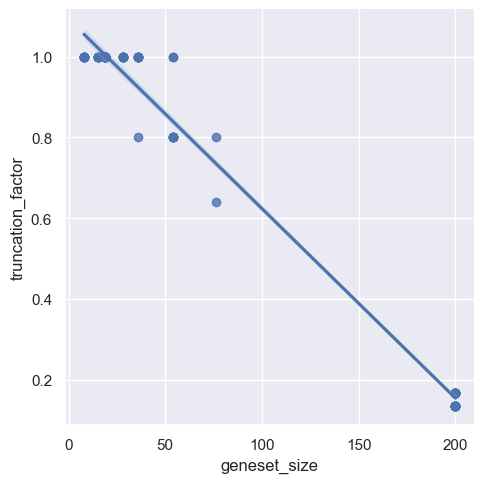

In [68]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

<Axes: xlabel='geneset_size', ylabel='truncation_factor'>

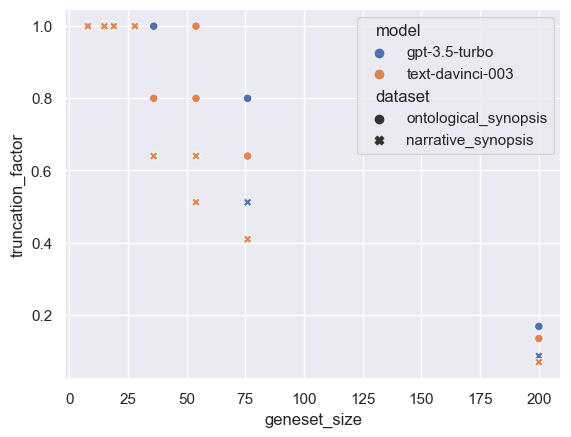

In [69]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [70]:
    df.query(f"{GENESET_SIZE} < 75")[[SOURCE_GENESET]].drop_duplicates()

,source_geneset
0,EDS
40,FA
200,amigo-example
250,term-GO:0007212
290,meiosis I
370,peroxisome
410,sensory ataxia


In [75]:
df.query(f"{GENESET_SIZE} < 75")[eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)

has_top_hit  in_top_5  in_top_10  \
model            method                                                   
N/A              random                   0.000000  0.000000   0.000000   
                 rank_based               0.000000  0.000000   0.000000   
                 standard                 1.000000  1.000000   1.000000   
                 standard_no_ontology     0.000000  0.000000   0.000000   
gpt-3.5-turbo    narrative_synopsis       0.392857  0.392857   0.392857   
                 no_synopsis              0.321429  0.321429   0.321429   
                 ontological_synopsis     0.464286  0.464286   0.464286   
text-davinci-003 narrative_synopsis       0.142857  0.142857   0.142857   
                 no_synopsis              0.142857  0.142857   0.142857   
                 ontological_synopsis     0.285714  0.214286   0.285714   

                                       size_overlap  similarity  
model            method                                          
N/A              random                    1.142857    0.007478  
                 rank_based                2.071429    0.014393  
                 standard                106.892857    1.000000  
                 standard_no_ontology      0.000000    0.000000  
gpt-3.5-turbo    narrative_synopsis        1.678571    0.031607  
                 no_synopsis               2.035714    0.021605  
                 ontological_synopsis      2.464286    0.039981  
text-davinci-003 narrative_synopsis        1.500000    0.012771  
                 no_synopsis               1.250000    0.011657  
                 ontological_synopsis      2.607143    0.027585

## Sensory Ataxia

In [82]:
df.query(f"{GENESET} == 'sensory ataxia-0' and model != 'N/A'").sort_values("similarity", ascending=False)[eval_summary_cols]

,model,method,has_top_hit,in_top_5,in_top_10,size_overlap,similarity
411,gpt-3.5-turbo,ontological_synopsis,True,True,True,2,0.200000
412,gpt-3.5-turbo,narrative_synopsis,False,False,False,2,0.166667
432,gpt-3.5-turbo,narrative_synopsis,True,True,True,1,0.083333
431,gpt-3.5-turbo,ontological_synopsis,True,True,True,1,0.076923
415,text-davinci-003,narrative_synopsis,False,False,False,1,0.047619
410,gpt-3.5-turbo,no_synopsis,False,False,False,0,0.000000
413,text-davinci-003,no_synopsis,False,False,False,0,0.000000
414,text-davinci-003,ontological_synopsis,False,False,False,0,0.000000
430,gpt-3.5-turbo,no_synopsis,False,False,False,0,0.000000
433,text-davinci-003,no_synopsis,False,False,False,0,0.000000


## Summaries

In [12]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [13]:
sdf = pd.DataFrame(objs)

In [14]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

,model,geneset,method,summary
0,None,EDS-0,gpt-3.5-turbo.no_synopsis,Summary: Genes associated with extracellular matrix organization and collagen metabolism are enriched in this set.\n
1,None,EDS-0,gpt-3.5-turbo.ontological_synopsis,Summary: Genes related to Ehlers-Danlos syndrome and connective tissue development.\n
2,None,EDS-0,gpt-3.5-turbo.narrative_synopsis,Summary: Genes associated with connective tissue disorders and extracellular matrix glycoproteins are over-represented.\n\n
3,None,EDS-0,text-davinci-003.no_synopsis,Summary:\nThe genes in this list are significantly enriched for terms related to cell-extracellular matrix interactions and connective tissue formation and maintenance.\n
4,None,EDS-0,text-davinci-003.ontological_synopsis,"\nSummary: The list of genes is enriched for terms associated with structural components of the extracellular matrix and processes related to collagen and matrix organization, including collagen fibril organization, extracellular matrix organization, collagen biosynthetic process, and negative regulation of transcription by RNA polymerase II.\n"
5,None,EDS-0,text-davinci-003.narrative_synopsis,"Summary: The above genes are involved in the synthesis and organization of collagen and other related proteins in connective tissue, as well as wound healing and cell differentiation.\n"
6,None,EDS-1,gpt-3.5-turbo.no_synopsis,Summary: These genes are mainly involved in the extracellular matrix and collagen metabolism.\n
7,None,EDS-1,gpt-3.5-turbo.ontological_synopsis,Summary: The
8,None,EDS-1,gpt-3.5-turbo.narrative_synopsis,"Summary: These genes are involved in connective tissue development and disorders, specifically related to collagen synthesis and regulation. \n\n"
9,None,EDS-1,text-davinci-003.no_synopsis,"\nSummary: The provided genes are involved in the development of connective tissue, such as bones and cartilage, as well as in collagen biosynthesis and glycosaminoglycan metabolism.\n\n"


In [15]:
sdf.query("geneset == 'sensory ataxia-0'")

,model,geneset,method,summary
264,None,sensory ataxia-0,gpt-3.5-turbo.no_synopsis,"Summary: The listed genes are involved in various biological processes related to neurological disorders, metabolic disorders, and protein folding.\n\n"
265,None,sensory ataxia-0,gpt-3.5-turbo.ontological_synopsis,Summary: Genes are mostly involved in neurological disorders and myelination of the peripheral nervous system. \n
266,None,sensory ataxia-0,gpt-3.5-turbo.narrative_synopsis,"Summary: Genes involved in neurological and mitochondrial disorders, myelin maintenance, protein degradation, and nucleo-cytoplasmic transport.\n"
267,None,sensory ataxia-0,text-davinci-003.no_synopsis,"\nSummary: This list of genes is associated with protein transportation, cellular structure, and DNA coding.\n"
268,None,sensory ataxia-0,text-davinci-003.ontological_synopsis,"Summary: Seven out of the eleven genes as mentioned above are associated with Charcot-Marie-Tooth disease or other neuromuscular diseases, suggesting that these genes are enriched for functions related to nerve cell development, nerve impulse transmission, and myelination in peripheral nervous system.\n"
269,None,sensory ataxia-0,text-davinci-003.narrative_synopsis,\nSummary: These genes are all related to neurological disorders and are involved in different aspects of neural development and maintenance.\n
276,None,sensory ataxia-0,gpt-3.5-turbo.no_synopsis,"Summary: Genes in this list are enriched for functions related to neurological and mitochondrial disorders, protein folding and transport, and RNA synthesis and processing.\n\n"
277,None,sensory ataxia-0,gpt-3.5-turbo.ontological_synopsis,"Summary: Genes are involved in various processes related to nervous system development and function, including myelination, axonal transport, and protein degradation.\n"
278,None,sensory ataxia-0,gpt-3.5-turbo.narrative_synopsis,"Summary: Genes associated with various types of peripheral neuropathies, myelin upkeep, and mitochondrial DNA replication are enriched for terms related to nervous system development and myelination.\n\n"
279,None,sensory ataxia-0,text-davinci-003.no_synopsis,"Summary: The genes in this list are primarily involved in neuronal development, organ and cell morphology, and cytoskeletal activities.\n"


In [16]:
testdf = pd.DataFrame([{"x": 1, "b": True}, {"x": 1, "y":2}, {"x": 2, "y": 2}])
testdf

,x,b,y
0,1,True,NaN
1,1,NaN,2.0
2,2,NaN,2.0


In [17]:
testdf.mean(numeric_only=True)

x    1.333333
y    2.000000
dtype: float64

In [18]:
testdf.groupby("x").mean(numeric_only=True)

,y
x,
1,2.0
2,2.0
